# Image Classification: Dogs vs. Cats Competition

This example shows how to implement a transfer learning solution to solve image classification problems. Data from the 
[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) Kaggle competition is used in this example. 

The goal of this competition is to build a model that identifies which animal - dog or cat - is in the image. Accordingly, it is a binary classification problem (1=dog, 0=cat). The training data contains 25 000 labeled images of dogs and cats.

Several parts of this example were based on [Deep Learning with Python](https://amzn.to/2CeEySF). Other important references are [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf) and [Tang (2013)](https://arxiv.org/pdf/1306.0239.pdf), which were used to develop the global average pooling and the linear support vector machines solutions, respectively.

**Dataset**
* Inputs: Images of dogs and cats.
* Outputs: Classification labels (1=dog, 0=cat).
* You can download the original dataset from this [link](https://www.kaggle.com/c/dogs-vs-cats/data).

**Error metric**
* Percentage of correctly labeled images (accuracy). 
* This error metric is defined by [Kaggle](https://www.kaggle.com/c/dogs-vs-cats#evaluation).

**Evaluation protocol**
* Fully-connected layers: Hold-out validation. 
* Global average pooling: Hold-out validation.
* Support vector machines: K-fold cross-validation.

**Performance goals**
* Accuracy > 0.85

**Solutions**
1. [Fully-connected layers](#1.-Fully-connected-layers)
1. [Global average pooling](#2.-Global-average-pooling)
1. [Linear support vector machines](#3.-Linear-support-vector-machines)

---

# 1. Fully-connected layers

## 1.1. Data preparation

### Import data

As I mentioned before, the dataset has 25 000 images of dogs and cats (12 500 from each class). This is a large dataset, which will hardly run on my computer. Accordingly, I will create a shorter dataset to build my model. This dataset will contain three subsets:
1. Training set with 200 samples of each class.
1. Validation set with 100 samples of each class.
1. Test set with 100 samples of each class.

To create this new dataset I used the script *import_dogs_cats.py*, which is based on [Chollet's book](https://amzn.to/2NEqnIH). The results achieved in this exercise would be much better if a larger dataset was used.

In [1]:
# Create new dataset
%run ./import_dogs_cats.py

total training cat images: 100
total training dog images: 100
total validation cat images: 50
total validation dog images: 50
total test cat images: 50
total test dog images: 50


So now we have a balanced dataset with:
* 200 training images (100 cats + 100 dogs).
* 100 validation images (50 cats + 50 dogs).
* 100 test images (50 cats + 50 dogs).

Indeed, an economic dataset. 

Let's display some pictures to see if everything looks ok.

In [2]:
# Base variables
base_dir = '/Users/macbook/book/dogs_cats/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

train_size, validation_size, test_size = 200, 100, 100

img_width, img_height = 224, 224  # Default input size for VGG16

Using TensorFlow backend.
/Users/macbook/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


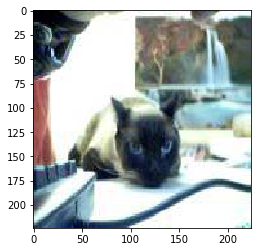

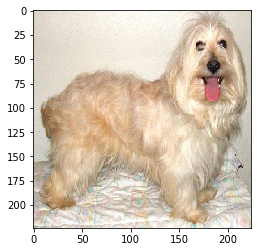

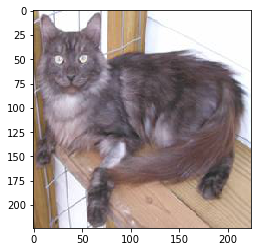

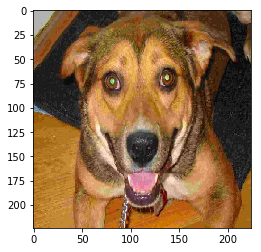

In [3]:
# Show pictures
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_cats_dir)
    show_pictures(train_dogs_dir)

A set of lovely dogs and cats. Everything seems to be working as expected.

### Extract features

In this example, we want to use a solution based on pre-trained models. We will use models that are composed of two parts:
* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as dog or cat. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

Now let's see how to extract features from a convolutional base.

In [4]:
# Instantiate convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

Line by line, what we are doing in VGG16 is:
* **weights** initializes model's weights. Here we are saying that we want to use the same weights as [ImageNet](http://www.image-net.org/). This is smart because we know that our dataset is similar to the ImageNet dataset (i.e. it has dogs and cats).
* **include_top** as false means that we want to train our own classifier on top of the convolutional base. The original VGG16 classifies images according to a set of 1 000 possible classes. Here we are just classifying our images as 'dogs' or 'cats'. 
* **input_shape** defines the shape of the image tensors that will feed the network. We used the default input size of VGG16 (224x224), but we could have used a different shape. For example, [Chollet](https://amzn.to/2pU8OuM) uses 150x150.

We can now check the architecture of the convolutional base that we instantiated.

In [5]:
# Check architecture
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Ok, now that we have the convolutional base, we need to pass our images through it for feature extraction.

In [6]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In the code above, we used *flow_from_directory*. When we use this method, the labels are inferred from the directory structure. This is an important detail to understand the code. For further details on how *flow_from_directory* works, I recommend you to read this [blog post](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2).

Let's just do a quick debug to see if everything is ok.

In [7]:
# Debug
print(train_features)
print(train_labels)

[[[[1.82692751e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.10146582e+00 0.00000000e+00]
   [6.42356634e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.87289083e-01 0.00000000e+00]
   [3.49128097e-01 0.00000000e+00 3.73788565e-01 ... 0.00000000e+00
    7.17178702e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 5.74068189e-01 ... 5.65039366e-02
    8.34508657e-01 0.00000000e+00]
   [4.18749034e-01 0.00000000e+00 4.42826450e-01 ... 0.00000000e+00
    6.61167145e-01 0.00000000e+00]
   [5.59691250e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.63677788e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.62488846e-02
    1.23500705e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.78762674e-01 ... 4.78821099e-01
    1.13595152e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 5.44967949e-01 ... 0.00000000e+00
    8.80614758e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 7.61949480e-01 ... 2.35

Ok, looks nice. Each sample has a wide range of features and labels are 0 or 1.

Now that we have the features, we can use any of the three classifiers that we suggest in this example. Accordingly, on top of our convolutional base, we will add a classifier and then our model is ready to make predictions.

In the next section, we will solve the problem using the most common solution: fully-connected layers.

# 1.2. Modeling

Here we will see how to build a classifier based on fully-connected layers. This classifier will use the features extracted from the convolutional base.

There are several models possible. You can add more layers, more neurons, use different optimizers, or any other modification. To keep it simple (and fast), we will use the solution proposed by Chollet in his [book](https://amzn.to/2pU8OuM) with slight variations. In particular, we will use the Adam optimizer instead of the RMSProp because [Stanford says so](http://cs231n.github.io/neural-networks-3/#adam) (what a beautiful *argumentum ad verecundiam*).

In [8]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [10]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 2s - loss: 2.9521 - acc: 0.5900 - val_loss: 2.3528 - val_acc: 0.5000
Epoch 2/100
200/200 [==============================] - 1s - loss: 1.3033 - acc: 0.6850 - val_loss: 0.5219 - val_acc: 0.7000
Epoch 3/100
200/200 [==============================] - 1s - loss: 0.8253 - acc: 0.7550 - val_loss: 0.7768 - val_acc: 0.7600
Epoch 4/100
200/200 [==============================] - 1s - loss: 0.3003 - acc: 0.8850 - val_loss: 0.4023 - val_acc: 0.8100
Epoch 5/100
200/200 [==============================] - 1s - loss: 0.2414 - acc: 0.9000 - val_loss: 0.5071 - val_acc: 0.8000
Epoch 6/100
200/200 [==============================] - 1s - loss: 0.0837 - acc: 0.9650 - val_loss: 0.3704 - val_acc: 0.8600
Epoch 7/100
200/200 [==============================] - 1s - loss: 0.0788 - acc: 0.9750 - val_loss: 0.5023 - val_acc: 0.8100
Epoch 8/100
200/200 [==============================] - 1s - loss: 0.0730 - acc: 0.9800

200/200 [==============================] - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.6030 - val_acc: 0.8400
Epoch 67/100
200/200 [==============================] - 1s - loss: 7.9415e-04 - acc: 1.0000 - val_loss: 0.6067 - val_acc: 0.8400
Epoch 68/100
200/200 [==============================] - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5961 - val_acc: 0.8400
Epoch 69/100
200/200 [==============================] - 1s - loss: 8.2291e-04 - acc: 1.0000 - val_loss: 0.5929 - val_acc: 0.8400
Epoch 70/100
200/200 [==============================] - 1s - loss: 5.4794e-04 - acc: 1.0000 - val_loss: 0.5917 - val_acc: 0.8400
Epoch 71/100
200/200 [==============================] - 1s - loss: 9.5266e-04 - acc: 1.0000 - val_loss: 0.5964 - val_acc: 0.8500
Epoch 72/100
200/200 [==============================] - 1s - loss: 5.3188e-04 - acc: 1.0000 - val_loss: 0.6002 - val_acc: 0.8500
Epoch 73/100
200/200 [==============================] - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.5970 - val_acc: 

In [11]:
# Save model
model.save('dogs_cat_fcl.h5')

## 1.3. Model evaluation

Model evaluation is an essential part of the work because it allows you to see how your solution is performing. Often, you'll find bugs in your code during this step, as well as ideas on how to improve your model.

Here, we will not go much into detail. Accordingly, we will just check the [learning curves](http://pmarcelino.com/how-to-read-learning-curves-and-why-do-we-need-them-in-deep-learning/) and visualize the model in action  for a random set of pictures. If you want to know more about the subject, you can read the [Practical Methodology](https://www.deeplearningbook.org/contents/guidelines.html) chapter of [Deep Learning](https://amzn.to/2RLcdJ0).

### Learning curves

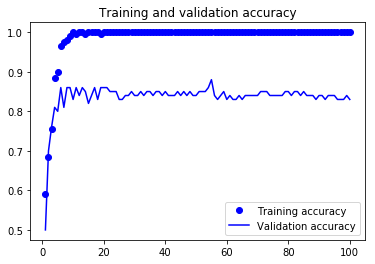

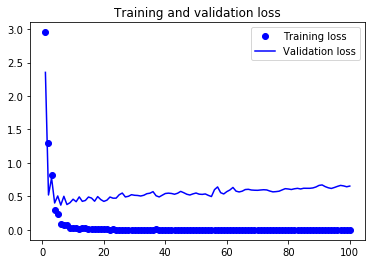

In [12]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model in action

In [13]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_cats_dir, test_dogs_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Cat')
        else:
            print('Dog')

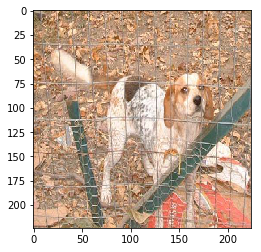

Dog


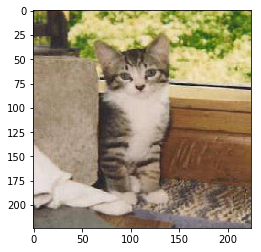

Cat


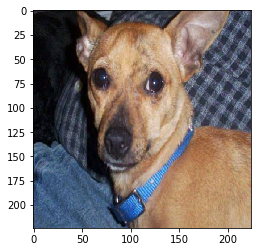

Dog


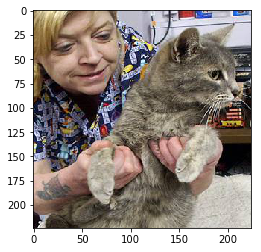

Cat


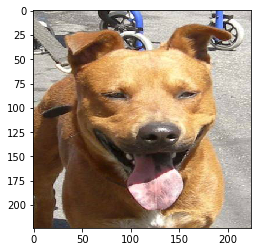

Dog


In [14]:
# Visualize predictions
visualize_predictions(model, 5)

**Comments**
* Validation accuracy is around 0.85, which barely achieves our performance goals.
* The model strongly overfits. There's a big gap between the training and the validation curves.
* Since we already used dropout, we should increase the size of the dataset.

# 2. Global average pooling

## 2.1. Data preparation

In this case, we don't need to preprocess the data. We will just use the features extracted from the convolutional base to feed the classifier.

## 2.2. Modelling

The difference between this case and the previous one is that, instead of adding a stack of fully-connected layers, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

Note that we are talking about a sigmoid activated layers instead of a softmax one, which is what is recommended by [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf). We are changing to the sigmoid activation because in Keras, to perform binary classification, you should use *sigmoid* activation and *binary_crossentropy* as the loss (see [Chollet's book](https://amzn.to/2Cdza25)). Accordingly, it was necessary to do this small modification to the original proposal of [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf).

In [15]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [17]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 0s - loss: 0.7857 - acc: 0.5000 - val_loss: 0.7341 - val_acc: 0.5000
Epoch 2/100
200/200 [==============================] - 0s - loss: 0.7074 - acc: 0.4950 - val_loss: 0.6982 - val_acc: 0.5200
Epoch 3/100
200/200 [==============================] - 0s - loss: 0.6877 - acc: 0.5750 - val_loss: 0.6902 - val_acc: 0.5300
Epoch 4/100
200/200 [==============================] - 0s - loss: 0.6843 - acc: 0.5150 - val_loss: 0.6869 - val_acc: 0.4600
Epoch 5/100
200/200 [==============================] - 0s - loss: 0.6780 - acc: 0.5500 - val_loss: 0.6783 - val_acc: 0.5300
Epoch 6/100
200/200 [==============================] - 0s - loss: 0.6674 - acc: 0.6150 - val_loss: 0.6678 - val_acc: 0.6100
Epoch 7/100
200/200 [==============================] - 0s - loss: 0.6570 - acc: 0.7000 - val_loss: 0.6600 - val_acc: 0.6500
Epoch 8/100
200/200 [==============================] - 0s - loss: 0.6493 - acc: 0.7200

200/200 [==============================] - 0s - loss: 0.4146 - acc: 0.8900 - val_loss: 0.4638 - val_acc: 0.8600
Epoch 66/100
200/200 [==============================] - 0s - loss: 0.4132 - acc: 0.9000 - val_loss: 0.4617 - val_acc: 0.8500
Epoch 67/100
200/200 [==============================] - 0s - loss: 0.4102 - acc: 0.9050 - val_loss: 0.4605 - val_acc: 0.8600
Epoch 68/100
200/200 [==============================] - 0s - loss: 0.4079 - acc: 0.9000 - val_loss: 0.4587 - val_acc: 0.8600
Epoch 69/100
200/200 [==============================] - 0s - loss: 0.4060 - acc: 0.9100 - val_loss: 0.4570 - val_acc: 0.8500
Epoch 70/100
200/200 [==============================] - 0s - loss: 0.4039 - acc: 0.9150 - val_loss: 0.4551 - val_acc: 0.8600
Epoch 71/100
200/200 [==============================] - 0s - loss: 0.4013 - acc: 0.9100 - val_loss: 0.4535 - val_acc: 0.8500
Epoch 72/100
200/200 [==============================] - 0s - loss: 0.4001 - acc: 0.9100 - val_loss: 0.4525 - val_acc: 0.8500
Epoch 73/100


In [18]:
# Save model
model.save('dogs_cat_gap.h5')

## 2.3. Model evaluation

### Learning curves

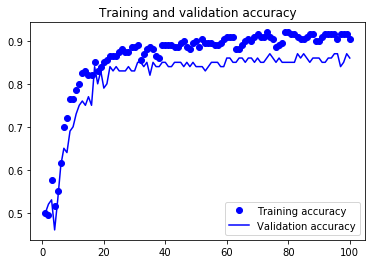

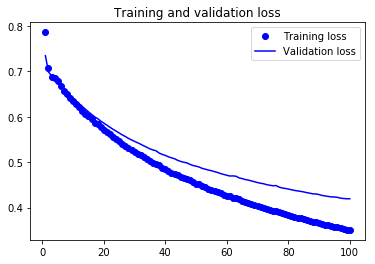

In [19]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model in action

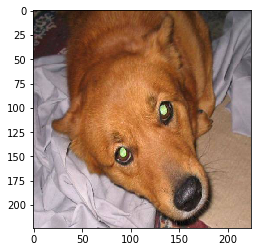

Dog


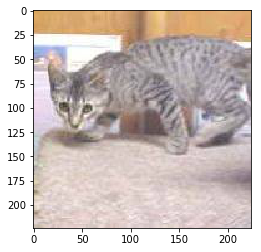

Cat


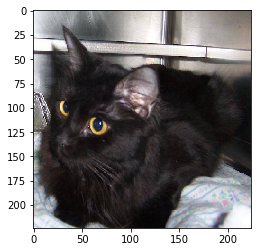

Cat


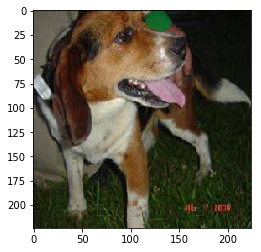

Dog


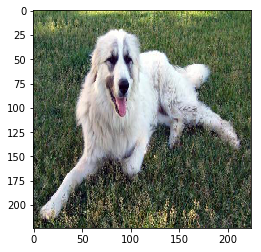

Dog


In [20]:
# Visualize predictions
visualize_predictions(model, 5)

**Comments**
* Validation accuracy is similar to the one resulting from the fully-connected layers solution.
* The model doesn't overfit as much as in the previous case.
* Training and validation loss have higher values than in the fully-connected model.
* It seems that the model could benefit from some training more (increase the number of epochs).

# 3. Linear support vector machines

## 3.1. Data preparation

In this case, we will train a linear SVM classifier on the features extracted by the convolutional base. To train this classifier, a traditional machine learning approach is preferable. Accordingly, we will use k-fold cross-validation to estimate the error of the classifier. Since k-fold cross-validation will be used, we can concatenate the train and the validation sets to enlarge our training data (we keep the test set untouched, as we did in the previous cases).

In [21]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

## 3.2. Modelling

The SVM classifier has one hyperparameter. This hyperparameter is the penalty parameter C of the error term. To optimize the choice of this hyperparameter, we will use [exhaustive grid search](http://scikit-learn.org/stable/modules/grid_search.html#grid-search).

In [22]:
# Build model
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(300,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

/Users/macbook/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/macbook/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [23]:
# Save model
model.save('dogs_cat_svm.h5')

## 3.3. Model evaluation

In [24]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
print("\nAccuracy score (standard deviation):")
print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))


Accuracy score (mean):
0.8600000000000001

Accuracy score (standard deviation):
0.04666666666666666


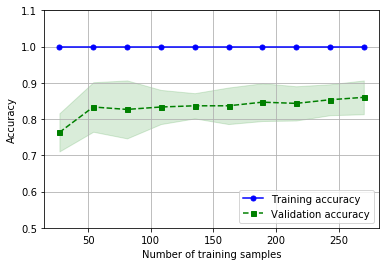

In [31]:
# Plot learning curves
from sklearn.model_selection import learning_curve
'''
train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10)
'''
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

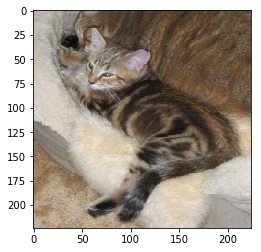

Cat


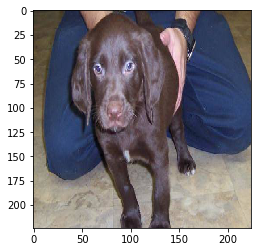

Dog


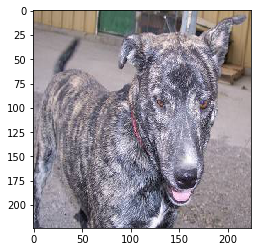

Cat


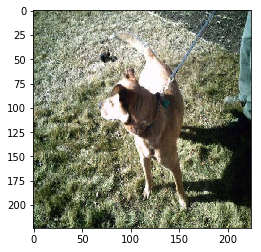

Dog


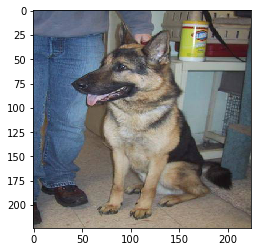

Dog


In [26]:
# Visualize predictions
visualize_predictions(clf, 5)

**Comments**
* Model's accuracy is around 0.86, which is similar to the accuracy of the previous solutions.
* Overfitting is around the corner. Moreover, the training accuracy is always 1.0, which is not usual and can be interpreted as a sign of overfitting. 
* The accuracy of the model should increase with the number of training samples. However, that doesn't seem to happen. This may be due to overfitting. It would be interesting to see how the model reacts when the dataset increases.

---

# Summary

In this example we:
* Showed how to use transfer learning to solve image classification problems.
* Used a pre-trained convolutional neural network model to extract features from pictures.
* Fed those features into different classifiers to build a prediction model.
* Tested classifiers based on fully-connected layers, global average pooling, and linear support vector machines.